# News Category Text-Classifier

$by: Jeremiah\space Chinyelugo$

In this notebook, we will create a news category text classifier using three (3) input features by leveraging the keras Functional API.<br/>

Most tutorials or projects online, utilize one (1) feature when creating a text classifier, or in few cases, figure out a clever way to combine features into one holistic feature to train a model. However, in this notebook, we will create a model that takes three (3) independent input features.

#### What is the *Keras Functional API*?
The *Keras Functional API* is way to create flexible model architures. This API is mostly used when creating deeply complex architectures, like Residual Networks or Deep and wide networks as opposed to the *Sequential API*. 

#### What the real-world applications of text classifiers?

Text classifiers have numerous real-world applications, some of which include:
1. Sentiment Analysis: Involves classifying text to determine the sentiment expressed, such as positive or negative. Use cases involve, analyzing customer feedback, social media monitoring or brand management.

2. Spam Filtering: Involves identifying and classifying emails as spam or ham. Useful for automatically filtering out unwanted or malicious content.

3. Fake News Detection: Identifying misleading or inaccurate articles or information. 

4. Document Classification: Identifying and categorizing large collections of documents based on their content.

#### Data

The [data](https://www.kaggle.com/datasets/rmisra/news-category-dataset?select=News_Category_Dataset_v3.json) used for this project was gotten from Kaggle. 

The dataset contains around 210k news headlines from 2012 to 2022 from HuffPost. This is one of the biggest news datasets and can serve as a benchmark for a variety of computational linguistic tasks. 

The dataset has 6 features:
- category: category in which the article was published.
- headline: the headline of the news article.
- authors: list of authors who contributed to the article.
- link: link to the original news article.
- short_description: Abstract of the news article.
- date: publication date of the article.

with our target (`category`) having **42** distinct values.

**citation**
1. Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).

#### Content


#### 1. Importing the relevant packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
import re
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

#### 2. Downloading the dataset

In [2]:
od.download("https://www.kaggle.com/datasets/rmisra/news-category-dataset?select=News_Category_Dataset_v3.json")

Skipping, found downloaded files in ".\news-category-dataset" (use force=True to force download)


#### 3. Loading and preprocessing the dataset

In [3]:
df = pd.read_json('./news-category-dataset/News_Category_Dataset_v3.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


Checking our dataset for null values

In [4]:
df.isnull().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [5]:
# dropping irrelevant features

df.drop(['link','date'], inplace=True, axis=1)

In [6]:
df

,headline,category,short_description,authors
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP"
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski
...,...,...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters"
209523,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",
209524,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,


We can see from our dataframe that we have some empty instances in the `authors` column, which leads us to believe we might have empty instances in other features as well. Therefore, we have to drop these instances as they will cause errors when training the model.

In [7]:
# dropping the instances

df = df[df['authors'] != '']
df = df[df['headline'] != '']
df = df[df['headline'] != ' ']
df = df[df['short_description'] != ' ']
df = df[df['short_description'] != '']

In [8]:
print(len(df[df['authors'] == '']))
print(len(df[df['headline'] == '']))
print(len(df[df['headline'] == ' ']))
print(len(df[df['short_description'] == '']))
print(len(df[df['short_description'] == ' ']))

0
0
0
0
0


In [9]:
# creating integer labels for our tagets

category_map = {v:k for k, v in enumerate(df['category'].unique())}

In [10]:
# mapping our target to create new labels

df['label'] = df['category'].map(category_map)
df.head()

,headline,category,short_description,authors,label
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",0
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,0
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,1
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,0


#### 4. Cleaning text

In [11]:
# creating the text cleaning function

def clean_text(text):
    text = text.lower()
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", '', text)
    text = re.sub(r"-", ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub(r"\s", " ", text)
    return text

In [12]:
# applying the cleaning function

for col in ['headline', 'short_description']:
    df[col] = df[col].map(clean_text)

#### 5. Splitting data

Our model will have three (3) inputs, so we need to slit our data into independent features

In [13]:
data_A = np.array(df['headline'].tolist())
data_B = np.array(df['short_description'].tolist())
data_C = np.array(df['authors'].tolist())

y = np.array(df['label'].tolist())

In [14]:
dataset_size = df.shape[0]

# creating our train and test set

rnd_perm = np.random.permutation(dataset_size)
train_idx, test_idx = rnd_perm[:int(dataset_size*0.8)], rnd_perm[int(dataset_size*0.8): ]

X_train_A, X_train_B, X_train_C, y_train = data_A[train_idx], data_B[train_idx], data_C[train_idx], y[train_idx]
X_test_A, X_test_B, X_test_C, y_test = data_A[test_idx], data_B[test_idx], data_C[test_idx], y[test_idx]

#### 5. Encoders

In [15]:
# normalizing our text data

import unicodedata

# Preprocess the text data
def preprocess_text(text):
    # Normalize the text using NFKD form
    text = unicodedata.normalize('NFKD', text)
    # Remove any non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('utf-8')
    return text

# Apply preprocessing to your input data
X_train_A = [preprocess_text(text) for text in X_train_A]
X_train_B = [preprocess_text(text) for text in X_train_B]
X_train_C = [preprocess_text(text) for text in X_train_C]

In [16]:
VOCAB_SIZE = 100_000

headline_encoder = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int'
)

headline_encoder.adapt(X_train_A)

In [17]:
# viewing our vocabulary

headline_vocab = np.array(headline_encoder.get_vocabulary())
headline_vocab[:10]

array(['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'for', 'and', 'is'],
      dtype='<U30')

In [18]:
# viewing our encoder

example = headline_encoder(X_train_A).numpy()

print(X_train_A[0])
example[0]

subway rats are actually the ultimate new yorkers so stop hating


array([2448, 7769,   22,  362,    2,  996,   16, 4264,  106,  153, 5377,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int64)

In [19]:
# short_description encoder

dscrp_encoder = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int'
)

dscrp_encoder.adapt(X_train_B)

dscrp_vocab = np.array(dscrp_encoder.get_vocabulary())

In [20]:
# authors encoder

author_encoder = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int'
)

author_encoder.adapt(X_train_C)

author_vocab = np.array(author_encoder.get_vocabulary())

#### Creating the functional model

In [21]:
keras.backend.clear_session()

input_A = keras.layers.Input(shape=(), dtype=tf.string, name='headline_input')
input_B = keras.layers.Input(shape=(), dtype=tf.string, name='short_description')
input_C = keras.layers.Input(shape=(), dtype=tf.string, name='authors')

headline_vec = headline_encoder(input_A)
description_vec = dscrp_encoder(input_B)
author_vec = author_encoder(input_C)

embedding_1 = keras.layers.Embedding(headline_vocab.size+1, 128, mask_zero=True)(headline_vec)
embedding_2 = keras.layers.Embedding(dscrp_vocab.size+1, 128, mask_zero=True)(description_vec)
embedding_3 = keras.layers.Embedding(author_vocab.size+1, 128, mask_zero=True)(author_vec)

conv_1 = keras.layers.Conv1D(128, kernel_size=2, activation='relu')(embedding_1)
conv_2 = keras.layers.Conv1D(128, kernel_size=2, activation='relu')(embedding_2)
conv_3 = keras.layers.Conv1D(128, kernel_size=2, activation='relu')(embedding_3)

dropout_1 = keras.layers.SpatialDropout1D(0.3)(conv_1)
dropout_2 = keras.layers.SpatialDropout1D(0.3)(conv_2)
dropout_3 = keras.layers.SpatialDropout1D(0.3)(conv_3)

conv_4 = keras.layers.Conv1D(256, kernel_size=2, activation='relu')(dropout_1)
conv_5 = keras.layers.Conv1D(256, kernel_size=2, activation='relu')(dropout_2)
conv_6 = keras.layers.Conv1D(256, kernel_size=2, activation='relu')(dropout_3)

gru_1 = keras.layers.Bidirectional(keras.layers.GRU(256))(conv_4)
gru_2 = keras.layers.Bidirectional(keras.layers.GRU(256))(conv_5)
gru_3 = keras.layers.Bidirectional(keras.layers.GRU(256))(conv_6)

concat = keras.layers.concatenate([gru_1, gru_2, gru_3], axis=1)

dropout_4 = keras.layers.Dropout(0.3)(concat)

hidden_1 = keras.layers.Dense(128, activation='relu')(dropout_4)
hidden_2= keras.layers.Dense(42, activation='softmax')(hidden_1)

model = keras.Model(inputs=[input_A, input_B, input_C], outputs=[hidden_2])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 headline_input (InputLayer)    [(None,)]            0           []                               
                                                                                                  
 short_description (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 authors (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, None)        0           ['headline_input[0][0]']         
 ization)                                                                                     

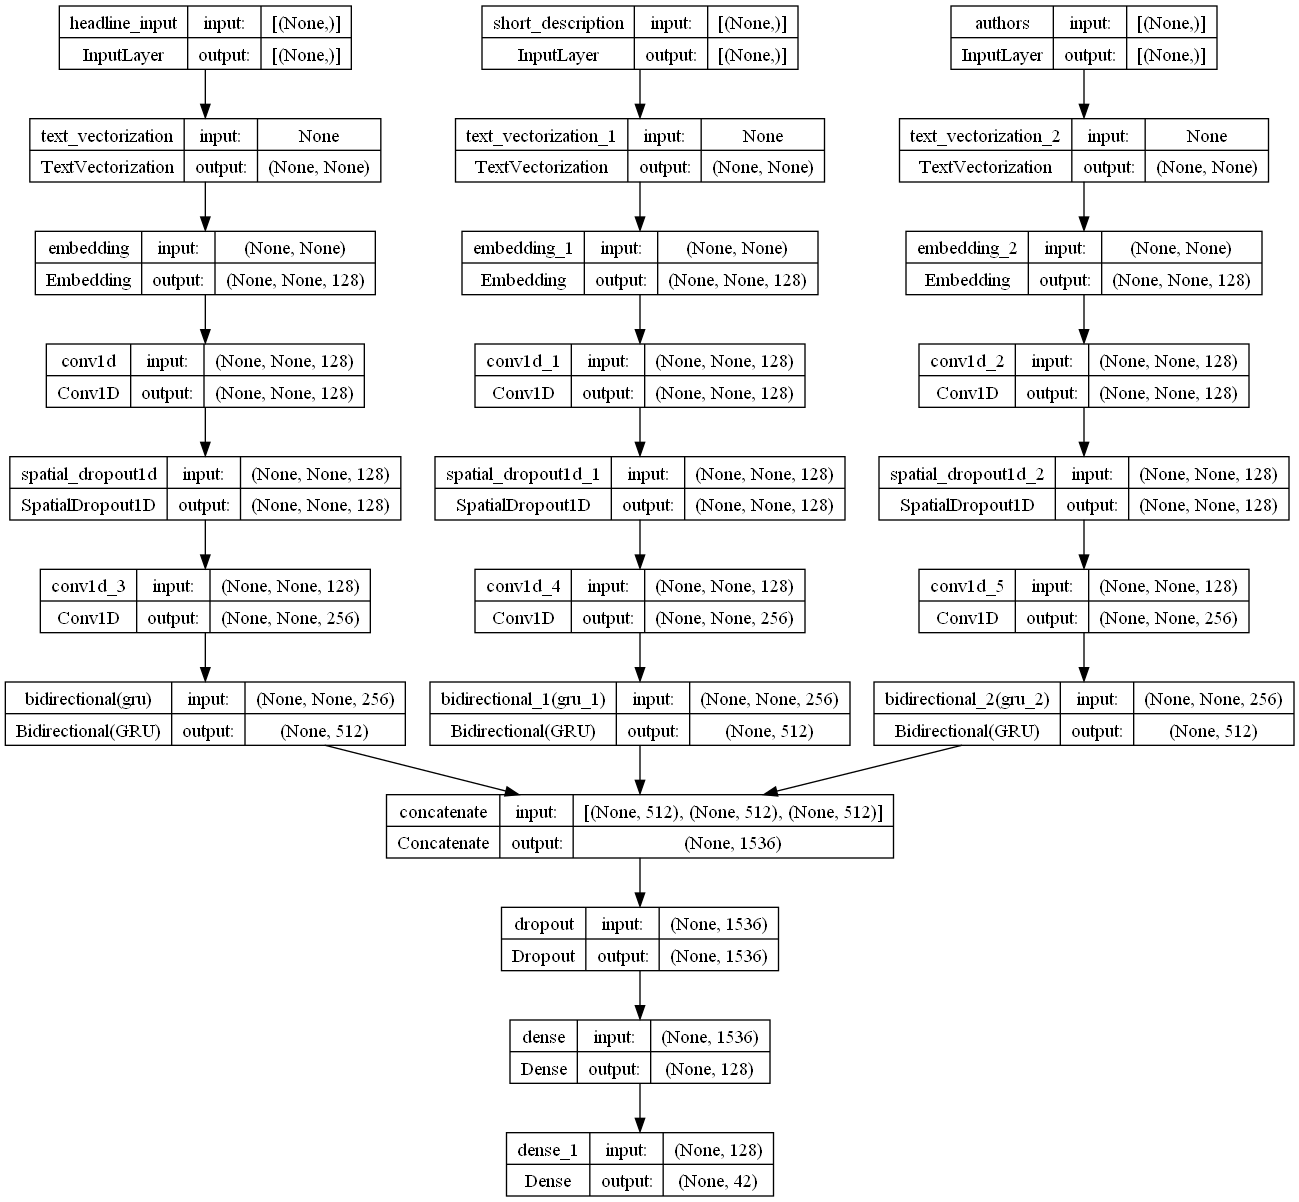

In [23]:
# visualizing our model 

keras.utils.plot_model(model, show_shapes=True)

In [24]:
# compiling the model

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [25]:
# converting our data to type -> tf.tensor

X_train_A = tf.convert_to_tensor(X_train_A)
X_train_B = tf.convert_to_tensor(X_train_B)
X_train_C = tf.convert_to_tensor(X_train_C)

y_train = tf.convert_to_tensor(y_train)

X_test_A = tf.convert_to_tensor(X_test_A)
X_test_B = tf.convert_to_tensor(X_test_B)
X_test_C = tf.convert_to_tensor(X_test_C)

y_test = tf.convert_to_tensor(y_test)

In [26]:
history = model.fit((X_train_A, X_train_B, X_train_C), y_train, epochs=5, validation_split=0.2, batch_size=16)

Epoch 1/5


c:\Users\jerem\miniconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6275/6275 [==============================] - 388s 60ms/step - loss: 2.0580 - accuracy: 0.4525 - val_loss: 1.5703 - val_accuracy: 0.5765
Epoch 2/5
6275/6275 [==============================] - 351s 56ms/step - loss: 1.3424 - accuracy: 0.6334 - val_loss: 1.3031 - val_accuracy: 0.6483
Epoch 3/5
6275/6275 [==============================] - 352s 56ms/step - loss: 1.0197 - accuracy: 0.7159 - val_loss: 1.2032 - val_accuracy: 0.6731
Epoch 4/5
6275/6275 [==============================] - 350s 56ms/step - loss: 0.8110 - accuracy: 0.7699 - val_loss: 1.1612 - val_accuracy: 0.6920
Epoch 5/5
6275/6275 [==============================] - 354s 56ms/step - loss: 0.6537 - accuracy: 0.8125 - val_loss: 1.1891 - val_accuracy: 0.6932


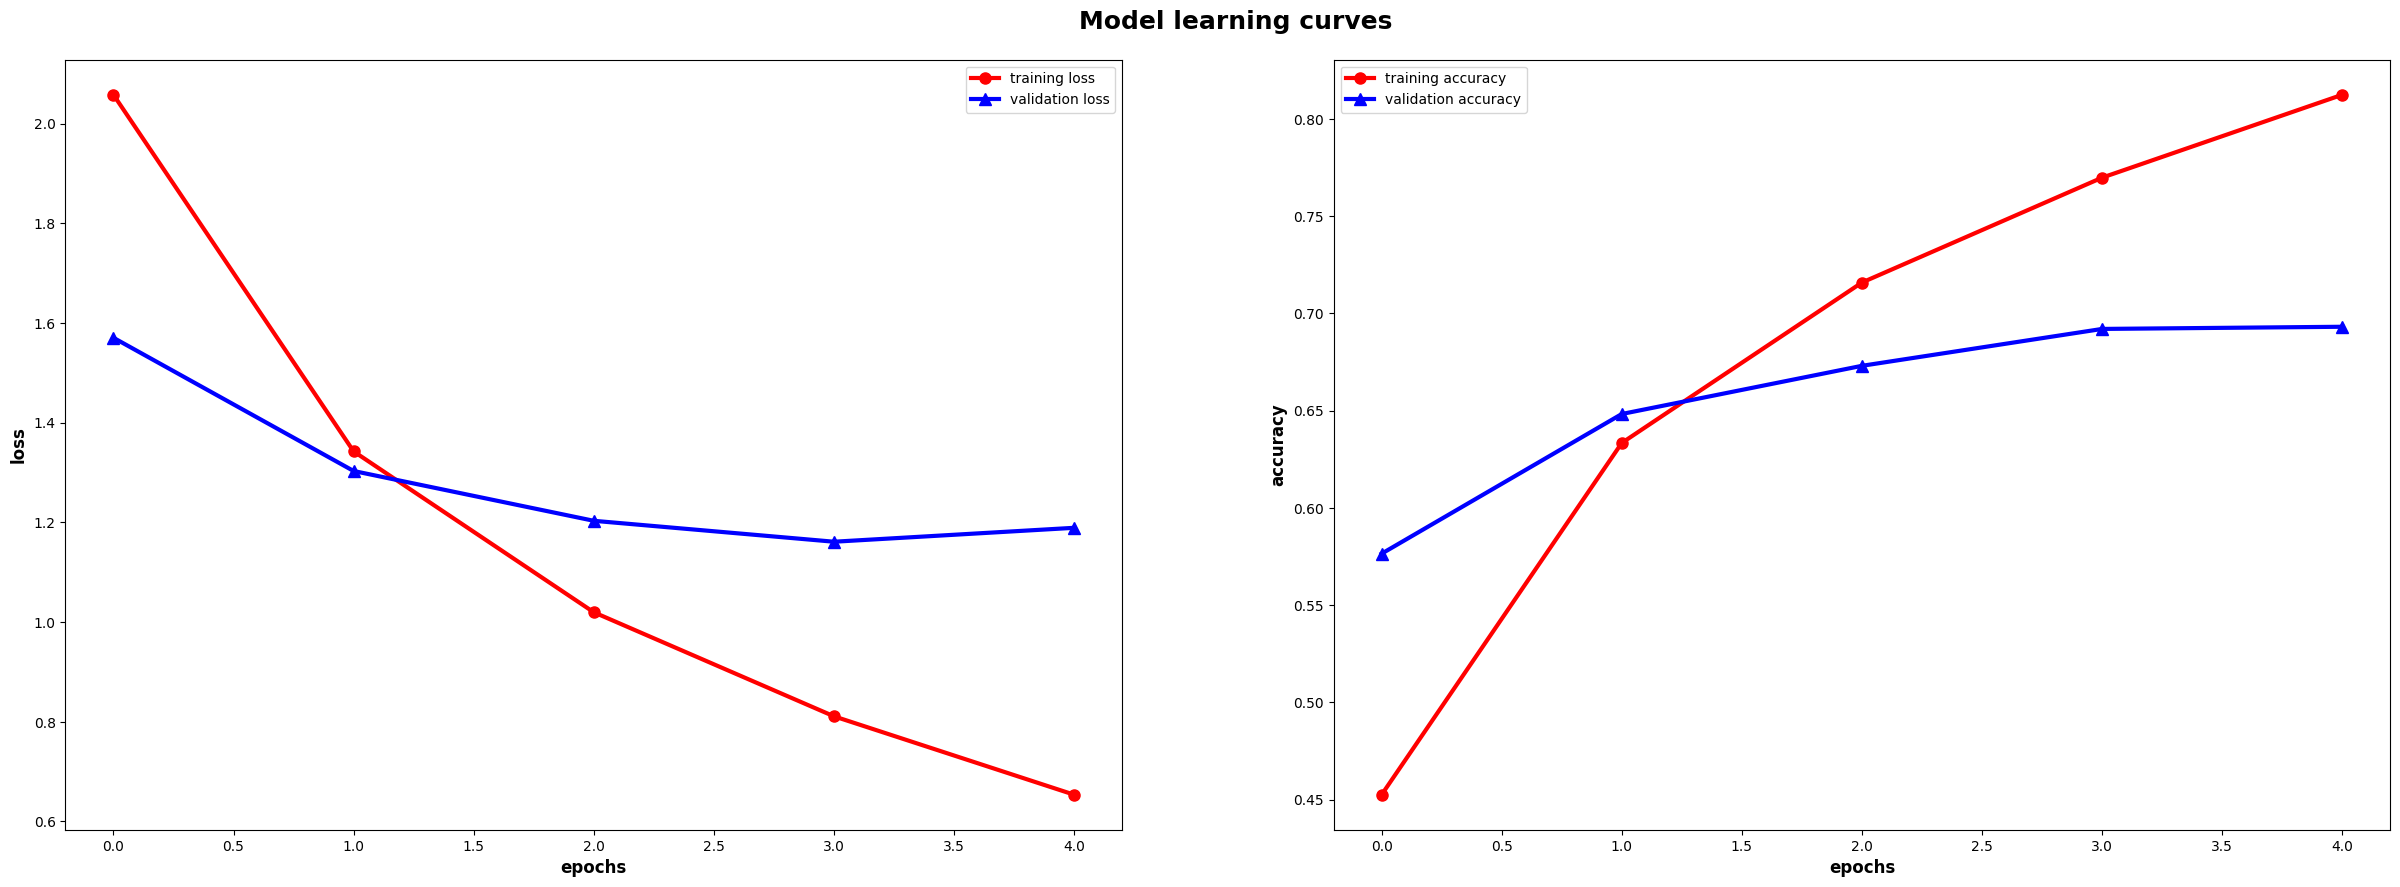

In [27]:
history_dict = history.history
    
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

ax[0].plot(list(range(len(history_dict['loss']))), history_dict["loss"], 'ro-', lw=3, markersize=8, label="training loss")
ax[0].plot(list(range(len(history_dict['loss']))), history_dict["val_loss"], 'b^-', lw=3, markersize=8, label="validation loss")

ax[1].plot(list(range(len(history_dict['loss']))), history_dict["accuracy"], 'ro-', lw=3, markersize=8, label="training accuracy")
ax[1].plot(list(range(len(history_dict['loss']))), history_dict["val_accuracy"], 'b^-', lw=3, markersize=8, label="validation accuracy")

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper left")

ax[0].set_xlabel("epochs", fontsize=12, weight='bold')
ax[1].set_xlabel("epochs", fontsize=12, weight='bold')

ax[0].set_ylabel("loss", fontsize=12, weight='bold')
ax[1].set_ylabel("accuracy", fontsize=12, weight='bold')

fig.text(0.515, .93, "Model learning curves", ha="center", va="top", fontsize=18, weight='bold')
plt.show()

From the training history, we can see that the model began to overfit. There are several wasy to counteract this. For example, we could add a kernel regularizer, add more dropout layers or increase the dropout rate.

However, due to the constraints of my personal GPU, we will not be tuning this model.

In [28]:
# model evaluation

scores = model.evaluate((X_test_A, X_test_B, X_test_C), y_test, verbose=False)

In [29]:
print(f"Test set accuracy: {scores[1]:.2%}")

Test set accuracy: 69.86%


Our model accuracy on the test set is roughly **`70%`** which is amazing!, considering that we didn't use a pretained model, and that most [notebooks](https://www.kaggle.com/datasets/rmisra/news-category-dataset/code?datasetId=32526&sortBy=voteCount) that used this data had an accuracy of around **`~64%`**. 

The only notebooks that had a higher accuracy, either 
- used a pre-trained BERT model with 335 million paramteters - `74%` accuracy
- used eleven (11) classes as opposed to all forty-two (42) classes - `72%` accuracy

(yes, i checked all accuracies because i didn't have better things to do)

In [30]:
pred = np.argmax(model.predict((X_test_A, X_test_B, X_test_C), verbose=False), axis=1)

In [31]:
conf_matrix = confusion_matrix(y_test, pred)
np.fill_diagonal(conf_matrix, 0)

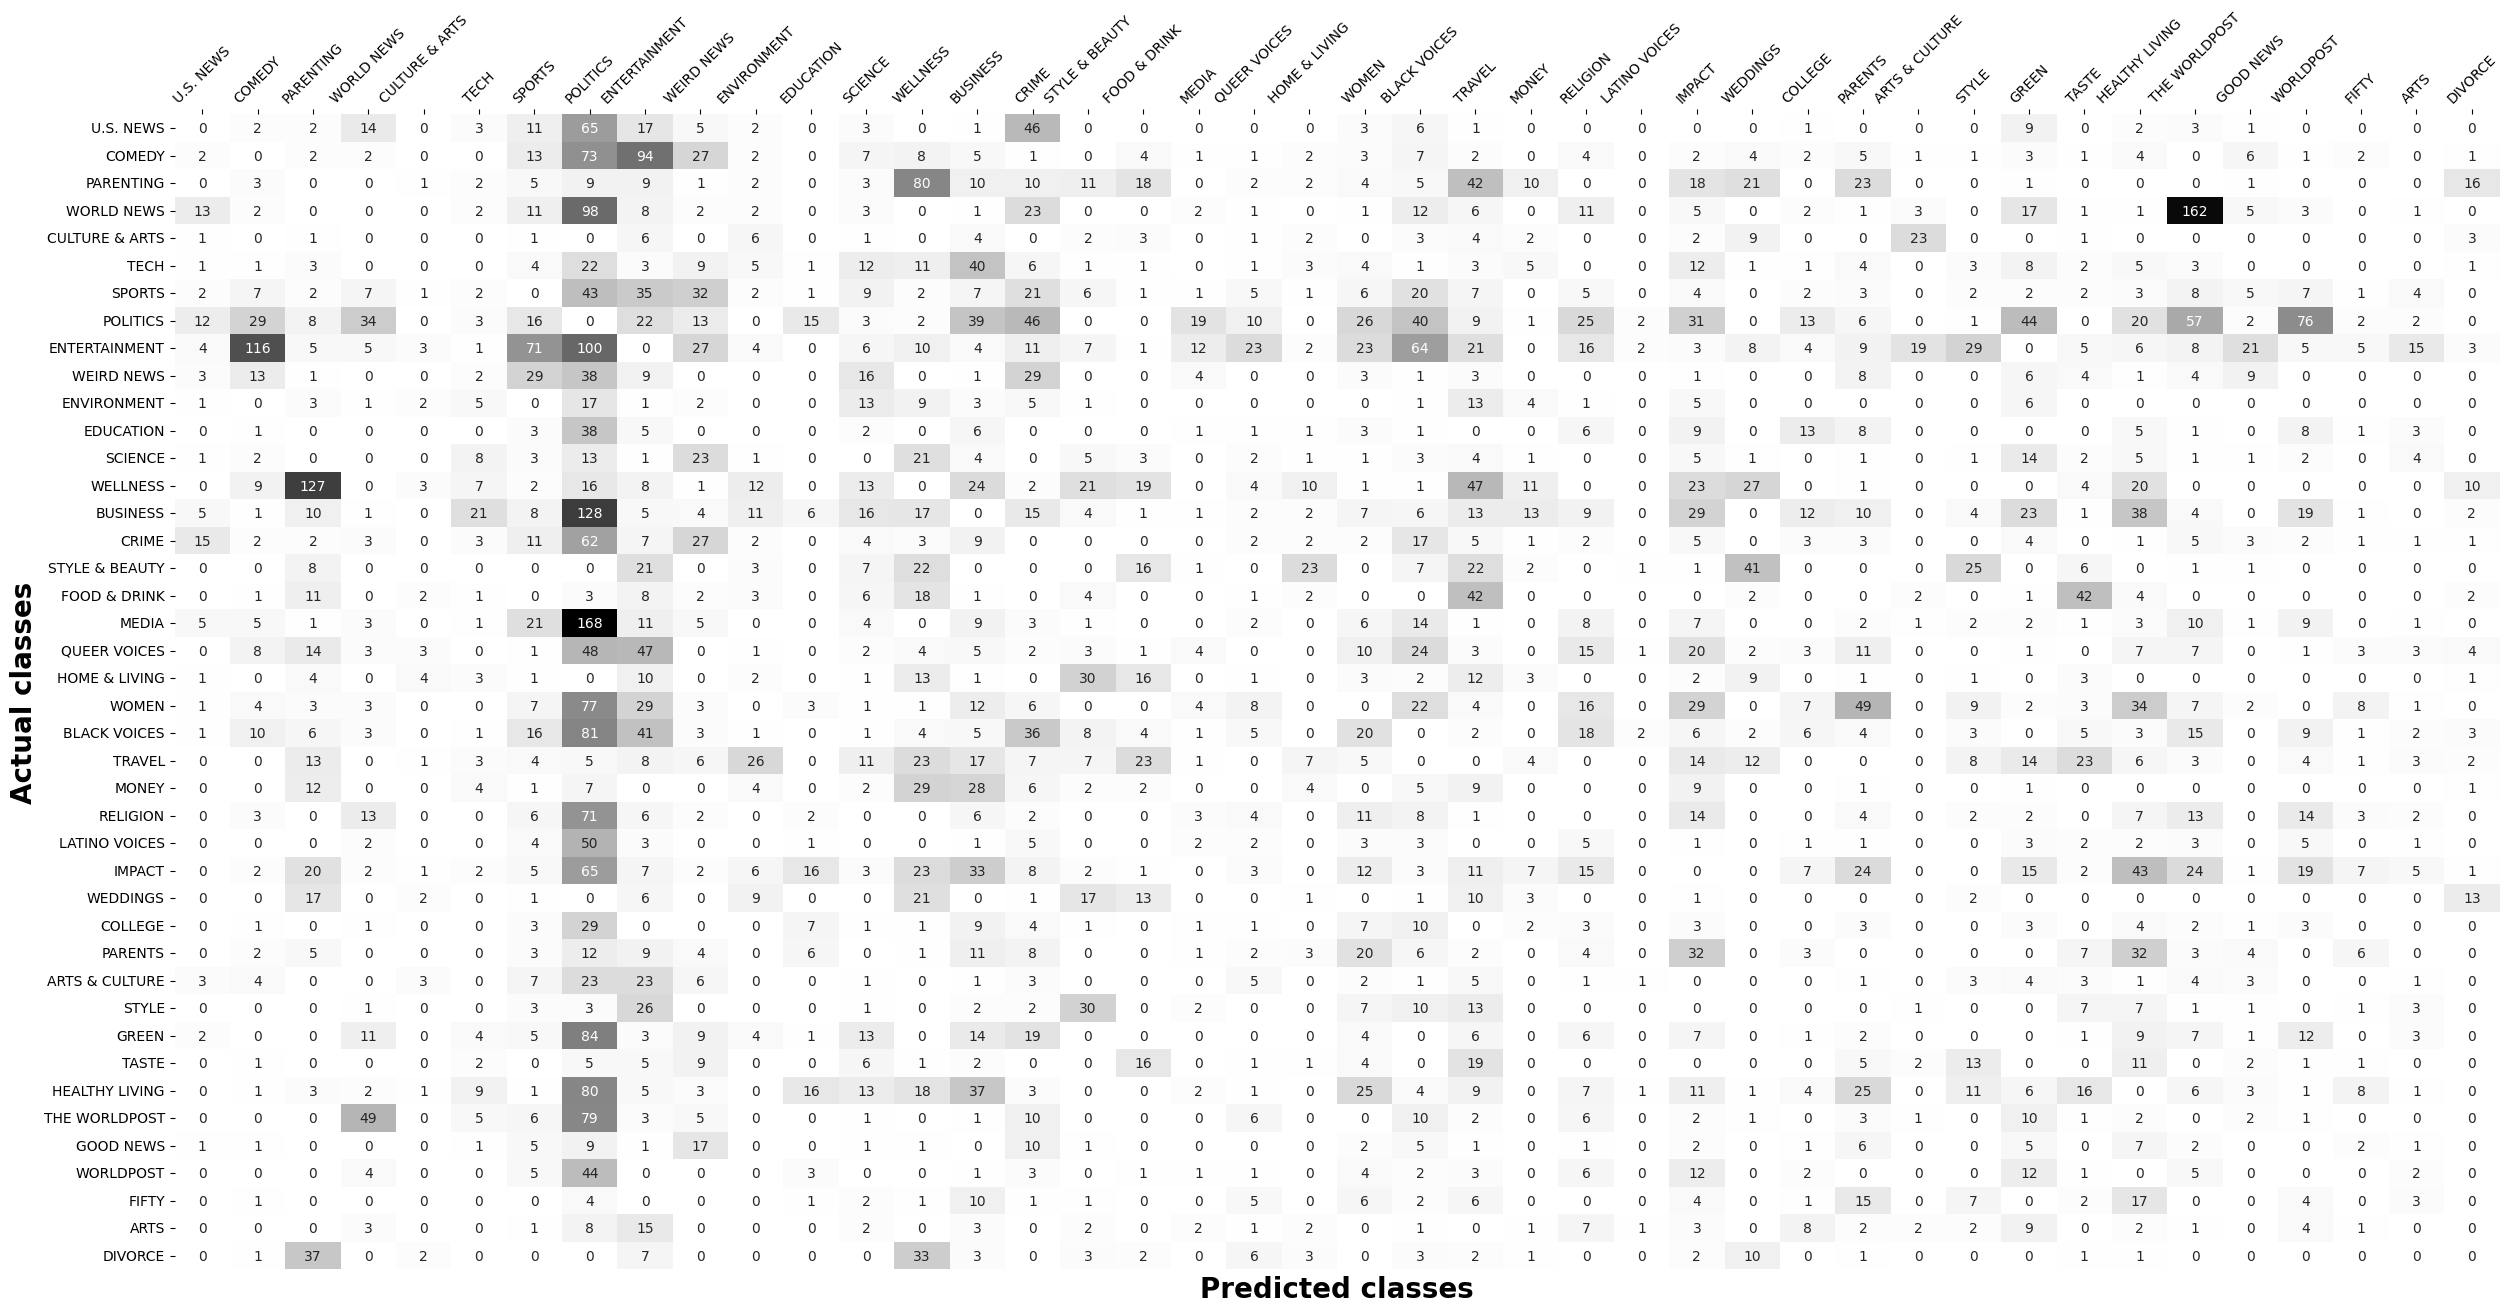

In [32]:
labels = list(category_map.keys())

plt.figure(figsize=(30,15))
g = sns.heatmap(conf_matrix, cmap='gray_r', annot=True, cbar=False, fmt='.0f')
g.set_xticklabels(labels=labels, rotation=45)
g.xaxis.tick_top()
g.set_yticklabels(labels=labels, rotation=0)

plt.xlabel('Predicted classes', fontsize=20, weight='bold')
plt.ylabel('Actual classes', fontsize=20, weight='bold')
plt.show()

By setting the diagonal values to zero (0), we can see which classes were misclassified.

From the heatmap above, we can see that the model could not differentiate between `(MEDIA` & `POLITICS)`, `(WELLNESS` & `PARENTING)`, `(ENTERTAINMENT` & `COMEDY)`. On the surface level, this might look bad, but what this tells us is that these topics are so similar (probably because they share keywords or authors) that the model could not differentiate them.

Overall, i believe the model performed well. Having to classify 42 different categories is not an easy feat. Humans would perform woefully if asked to classify News categories by looking at the author, headline or short description.

#### Model predictions

viewing our top 5 predicitions

In [33]:
for idx, (headline, description, author) in enumerate(zip(X_test_A[:5], X_test_B[:5], X_test_C[:5])):
    print(f"# {idx+1}")
    print("=======================================================================================================================================")
    print(f"News headline: {str(headline.numpy())}")
    print(f"Short description: {str(description.numpy())}")
    print(f"Author: {str(author.numpy())}\n")
    print(f"Actual class: {labels[y_test[idx]]}")
    print(f"Predicted class: {labels[pred[idx]]}")
    print("=======================================================================================================================================\n\n")

# 1
News headline: b'nicolle wallace donald trump greenlit a war in this country around race'
Short description: b'the msnbc host said it could be the most dangerous thing hes done'
Author: b'Lee Moran'

Actual class: MEDIA
Predicted class: POLITICS


# 2
News headline: b'the power of playing with healthy food'
Short description: b'young children are already establishing food preferences and its an important time to have good healthy snacks and meals good eating habits dont just happen    they are taught'
Author: b"Bill & Claire Wurtzel, Contributor\nAuthors, 'Funny Food: 365 Fun, Healthy, Silly, Creative Breakf..."

Actual class: FOOD & DRINK
Predicted class: FOOD & DRINK


# 3
News headline: b'the strange way my dad helped me learn about cancer'
Short description: b'as a teenager very little is more embarrassing than running your fingers over a fake scrotum under the instruction of your father  but i did it and before long i was glad that i had'
Author: b'Kevin Lankes, ContributorFre